# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"

graph_node_data = pd.read_csv(data_interim+"grafo_alternativo_nodos.csv")
graph_edge_data = pd.read_csv(data_interim+"grafo_alternativo_enlaces.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

,Número de nodos
bert_group,1067
complex,422
disease,15766
gene_protein,17363
pathway,2020
total,36638


,Número de enlaces
disease_disease,17488.0
form_complex,1888.0
gda,84038.0
pathway_protein,42646.0
ppi,110062.0
total,256122.0


In [4]:
display(graph_node_data.head())
display(graph_edge_data.head())
display(disease_attributes.head())

,node_index,node_id,node_name,node_type,node_source
0,0,1,A1BG,gene_protein,disgenet
1,1,10,NAT2,gene_protein,disgenet
2,2,100,ADA,gene_protein,disgenet
3,3,1000,CDH2,gene_protein,disgenet
4,4,10000,AKT3,gene_protein,disgenet


,edge_index,x_index,y_index,x_id,y_id,x_type,y_type,edge_type,edge_source,edge_source_index
0,0,0,19599,1,C0019209,gene_protein,disease,gda,disgenet,0.0
1,1,0,34251,1,R-HSA-114608,gene_protein,pathway,pathway_protein,primekg,NaN
2,2,0,653,1,10422,gene_protein,gene_protein,ppi,hippie,357083.0
3,3,0,13168,1,63891,gene_protein,gene_protein,ppi,hippie,358639.0
4,4,0,6638,1,284403,gene_protein,gene_protein,ppi,hippie,297494.0


,node_index,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
0,18431,C0000744,Abetalipoproteinemia,disease,8692.0,abetalipoproteinemia,Abetalipoproteinemia/ homozygous familial hypo...,An autosomal recessive disorder of lipid metab...,"A severe, familial hypobetalipoproteinemia cha...",C16;C18,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
1,18432,C0000768,Congenital Abnormality,group,839.0,congenital abnormality,"Any abnormality, anatomical or biochemical, ev...",Any abnormality either hereditary or due an in...,NaN,C16,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
2,18433,C0000771,"Abnormalities, Drug-Induced",group,16677.0,toxic or drug-related embryofetopathy,Congenital abnormalities caused by medicinal s...,Congenital abnormalities caused by medicinal s...,NaN,C16,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
3,18436,C0000809,"Abortion, Habitual",disease,6774.0,habitual spontaneous abortion,Three or more consecutive spontaneous abortions.,spontaneous expulsion of a dead or non-viable ...,NaN,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet
4,18437,C0000821,Threatened abortion,phenotype,4846.0,placental abruption (disease),Vaginal bleeding preceding the 20th week of ge...,Placental separation from the uterus with blee...,NaN,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet


# Armo grafo y subgrafos

In [5]:
def attributes_from_pd(G:nx.Graph,df:pd.DataFrame,attributes:dict,indexcol):
    """Dados un grafo G y un dataframe df con atributos de sus nodos, especificamos los atributos
    que queremos agregar a los nodos en un diccionario con formato {nombre_columna:nombre_atributo}. 
    La función arma un diccionario con los atributos y el nombre que le queremos poner, indexado con el identificador de nodo que elegimos 
    y los asigna a los nodos del grafo"""
    for attribute,name in attributes.items():
        nx.set_node_attributes(G,pd.Series(df.set_index(indexcol)[attribute]).to_dict(),name)

def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

def get_edge_dict(G):
    edge_dict = {}
    for edge_data in list(G.edges(data=True)):
        edge_index = edge_data[2]["edge_index"]
        edge_type = edge_data[2]["edge_type"]
        edge_source = edge_data[0]
        edge_target = edge_data[1]
        edge_dict[edge_index] = {"edge_type":edge_type, "nodes":(edge_source,edge_target)}
    return edge_dict

def get_edges_from(node_index):
    edges_from = graph_edge_data[(graph_edge_data.x_index == node_index)]
    return edges_from

Me quedo solo con la componente gigante

In [6]:
G_full = nx.from_pandas_edgelist(graph_edge_data,source="x_index",target="y_index", edge_attr=["edge_type","edge_index"])
G_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source"}

Gcc = sorted(nx.connected_components(G_full), key=len, reverse=True)
G = G_full.subgraph(Gcc[0]).copy()

nodos_en_cg = list(G.nodes())
graph_node_data = graph_node_data.loc[nodos_en_cg].sort_values(by="node_index")

graph_edge_data = graph_edge_data.set_index("x_index").loc[nodos_en_cg].reset_index()
graph_edge_data = graph_edge_data.set_index("y_index").loc[nodos_en_cg].reset_index()

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

# graph_node_data.to_csv(data_processed+"grafo_alternativo_CG_nodos.csv",index=False)
# graph_edge_data.to_csv(data_processed+"grafo_alternativo_CG_edges.csv",index=False)

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

,Número de nodos
bert_group,1043
complex,421
disease,15066
gene_protein,17322
pathway,2017
total,35869


,Número de enlaces
disease_disease,17432.0
form_complex,1885.0
gda,84024.0
pathway_protein,42643.0
ppi,110051.0
total,256035.0


Armo subgrafo de enfermedades

In [7]:
edges_enfermedades = graph_edge_data[graph_edge_data.edge_type == "disease_disease"]
nodos_enfermedades = graph_node_data[(graph_node_data.node_type == "disease") | (graph_node_data.node_type == "bert_group")]

disease_attributes["node_type"] = "disease"
nodos_bert = nodos_enfermedades[nodos_enfermedades.node_type == "bert_group"].copy()
nodos_bert["node_index"] = nodos_bert.index

disease_attributes = pd.concat([disease_attributes,nodos_bert])

DD = nx.from_pandas_edgelist(edges_enfermedades,source="x_index",target="y_index")
DD_attributes = {"node_name":"node_name","node_type":"node_type","node_id":"node_id","node_source":"node_source","disgenet_type":"disgenet_type","diseaseClassMSH":"diseaseClassMSH","diseaseClassNameMSH":"diseaseClassNameMSH"}
attributes_from_pd(DD,disease_attributes,DD_attributes,"node_index")

Armo subgrafos de proteínas y de asociaciones GDA

In [8]:
edges_proteinas = graph_edge_data[(graph_edge_data.edge_type == "ppi") | (graph_edge_data.edge_type == "form_complex") | (graph_edge_data.edge_type == "pathway_protein")]
nodos_proteinas = graph_node_data[(graph_node_data.node_type == "gene_protein") | (graph_node_data.node_type == "complex") | (graph_node_data.node_type == "pathway")]
PPI = nx.from_pandas_edgelist(edges_proteinas,source="x_index",target="y_index")
PPI_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source"}

edges_gda = graph_edge_data[graph_edge_data.edge_type == "gda"]
nodos_gda = graph_node_data[graph_node_data.node_source == "disgenet"]

GDA = nx.from_pandas_edgelist(edges_gda,source="x_index",target="y_index")
GDA_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source"}

for network,attr in zip([G,PPI,GDA],[G_attributes,PPI_attributes,GDA_attributes]):
    attributes_from_pd(network,graph_node_data,attr,"node_index")

In [9]:
graphs = {"Grafo completo":G, "Disease layer":DD, "Protein layer":PPI, "GDA": GDA}
stats = {name:{"Número de nodos":graph.number_of_nodes(), "Número de enlaces":graph.number_of_edges()} for name,graph in graphs.items()}
display(pd.DataFrame(stats))

,Grafo completo,Disease layer,Protein layer,GDA
Número de nodos,35869,12509,18525,20856
Número de enlaces,256035,17432,154579,84024


In [10]:
# nx.write_gml(GDA, data_processed+"graph_data/gda_network.gml")
# nx.write_gml(G,data_processed+"graph_data/full_graph_giant_component.gml")

Me quedo con la componente gigante

# Diferencio enlaces bert_disease de disease_disease

Esto es por si más adelante quiero tratarlos como algo diferente 

In [61]:
disease_mappings = pd.read_csv(data_processed+"graph_data/disease_mappings.csv")
bert_edges = pd.read_csv(data_processed+"graph_data/bert_edge_reference.csv").drop(columns=["Unnamed: 0"])

dd = graph_edge_data[graph_edge_data.edge_type == "disease_disease"]

temp_df = pd.merge(dd,bert_edges[["x_index","y_index","relation"]],left_on=["x_index","y_index"], right_on=["x_index","y_index"], how="inner").rename(columns={"relation":"disease_edge_type"})

bert_edges_inverted = bert_edges.rename(columns={"x_index":"y_index","y_index":"x_index"})

temp_df_inverted = pd.merge(dd,bert_edges_inverted[["x_index","y_index","relation"]],left_on=["x_index","y_index"], right_on=["x_index","y_index"], how="inner").rename(columns={"relation":"disease_edge_type"})

final_bert_edges = pd.concat([temp_df,temp_df_inverted])

final_bert_edges.to_csv(data_processed+"graph_data/disease_bert_edges.csv")

In [76]:
disease_edge_types = pd.merge(dd,final_bert_edges[["x_index","y_index","disease_edge_type"]], left_on=["x_index","y_index"], right_on=["x_index","y_index"],how="left")
disease_edge_types.disease_edge_type = disease_edge_types.disease_edge_type.fillna("disease_disease")
num_bert_map = disease_edge_types.disease_edge_type.value_counts()["disease_bert"]/2
display(pd.DataFrame(disease_edge_types.disease_edge_type.value_counts()/2))

,disease_edge_type
disease_disease,12452.0
disease_bert,4980.0


In [71]:
num_bert_mondo = len(disease_edge_types[(disease_edge_types.disease_edge_type == "disease_disease") & ((disease_edge_types.x_type == "bert_group")|(disease_edge_types.y_type == "bert_group"))])/2
num_true_disease_disease = len(disease_edge_types[(disease_edge_types.disease_edge_type == "disease_disease") & (disease_edge_types.x_type != "bert_group") & (disease_edge_types.y_type != "bert_group")])/2

In [80]:
num_bert_bert = len(disease_edge_types[(disease_edge_types.x_type == "bert_group") & (disease_edge_types.y_type == "bert_group")])/2

In [78]:
num_true_disease_disease+num_bert_mondo+num_bert_map

17432.0

In [87]:
display(pd.DataFrame.from_dict({"Count":{"Mapa disease-bert": num_bert_map, "Asociaciones bert-mondo (no mapa)":num_bert_mondo, "True disease-disease":num_true_disease_disease, "Bert-Bert (asociacion mondo)": num_bert_bert}}))

,Count
Asociaciones bert-mondo (no mapa),3800.0
Bert-Bert (asociacion mondo),448.0
Mapa disease-bert,4980.0
True disease-disease,8652.0


# Obtengo particiones de la red enfermedad-enfermedad

In [19]:
def particion_a_diccionario(Red_igraph,particion_igraph):
  particion_dict = {}
  for cluster in range(len(particion_igraph)):
    for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
      particion_dict.update({nodo:cluster})
  return particion_dict

def particiones(G):
    dict = {}
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_infomap  = G_igraph.community_infomap()
    dict_comunidades_infomap = particion_a_diccionario(G_igraph,comunidades_infomap)
    modularidad_infomap = G_igraph.modularity(comunidades_infomap)
    dict['Infomap'] = {'comunidades' : comunidades_infomap, 'diccionario':dict_comunidades_infomap, 'modularidad':modularidad_infomap}

    #LA FUNCIÓN COMMUNITY_MULTILEVEL DE IGRAPH UTILIZA EL ALGORITMO LOUVAIN
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_louvain = G_igraph.community_multilevel()
    dict_comunidades_louvain = particion_a_diccionario(G_igraph,comunidades_louvain)
    modularidad_louvain = G_igraph.modularity(comunidades_louvain)
    dict['Louvain'] = {'comunidades' : comunidades_louvain, 'diccionario':dict_comunidades_louvain, 'modularidad':modularidad_louvain}
    return dict

In [20]:
comunidades_dd = particiones(DD)

col_infomap = pd.Series(comunidades_dd['Infomap']['diccionario'],name="comunidades_infomap")
col_louvain = pd.Series(comunidades_dd['Louvain']['diccionario'],name="comunidades_louvain")

nx.set_node_attributes(DD,comunidades_dd['Infomap']['diccionario'],name="comunidad_infomap")
nx.set_node_attributes(DD,comunidades_dd['Louvain']['diccionario'],name="comunidad_louvain")

graph_node_data = pd.merge(graph_node_data,col_infomap,left_index=True,right_index=True, how="left")
graph_node_data = pd.merge(graph_node_data,col_louvain,left_index=True,right_index=True, how="left")

tamaños_infomap = pd.Series(col_infomap.value_counts(), name="tamaño")
tamaños_louvain = pd.Series(col_louvain.value_counts(), name="tamaño")

Graficos

Versión plotly

In [21]:
fig_dist_infomap = px.histogram(tamaños_infomap, title="Distribución de tamaños de clusters - Infomap",nbins=200).update_layout(xaxis_title="Tamaño")
fig_dist_infomap.show()

fig_dist_louvain = px.histogram(tamaños_louvain, title="Distribución de tamaños de clusters - Louvain", nbins=200).update_layout(xaxis_title="Tamaño")
fig_dist_louvain.show()

stats = {"Infomap":{"Num_clusters":len(tamaños_infomap),"Modularidad":round(comunidades_dd["Infomap"]["modularidad"],2)}, "Louvain":{"Num_clusters":len(tamaños_louvain),"Modularidad":round(comunidades_dd["Louvain"]["modularidad"],2)}}

display(pd.DataFrame(stats))

,Infomap,Louvain
Num_clusters,1141.00,266.00
Modularidad,0.78,0.87


Versión seaborn

Text(0.5, 0, 'Tamaño')

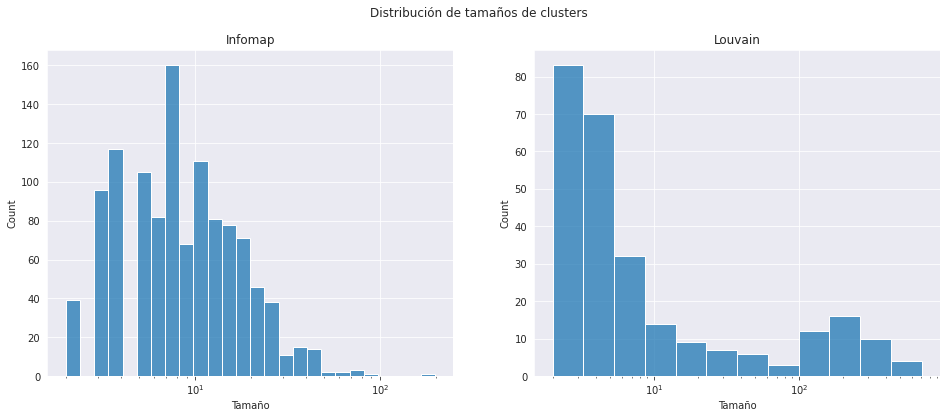

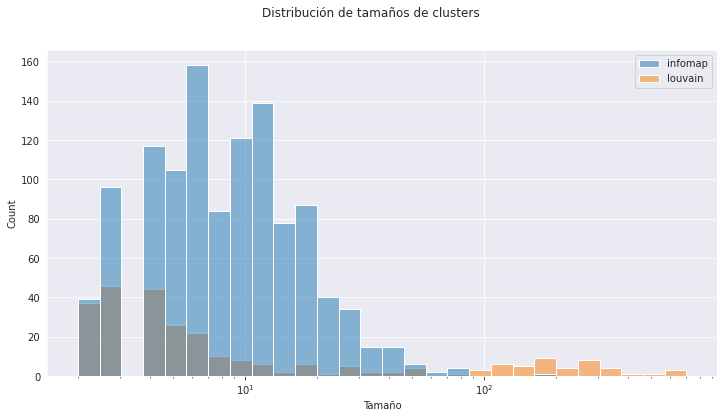

In [22]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Distribución de tamaños de clusters")
ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=tamaños_infomap, log_scale=True, ax=ax[0])
ax[0].set_xlabel("Tamaño")
ax[0].set_title("Infomap")

sns.histplot(data=tamaños_louvain, log_scale=True, ax=ax[1])
ax[1].set_xlabel("Tamaño")
ax[1].set_title("Louvain")

fig2, ax2 = plt.subplots(figsize=(12,6))
sns.histplot(data=pd.DataFrame({"infomap":tamaños_infomap,"louvain":tamaños_louvain}), log_scale=True,ax=ax2, palette="tab10")
fig2.suptitle("Distribución de tamaños de clusters")
ax2.set_xlabel("Tamaño")

Write data

In [73]:
#nx.write_gml(DD,data_processed+"grafo_alternativo_CG_disease_layer.gml")

# Distribución de grado

Veo distribución de grado para distintos sub grafos

In [24]:
def get_degree_series(G,name):
    degrees = {n[0]:G.degree(n[0]) for n in G.nodes(data=True)}
    return pd.Series(degrees,name=name)

In [26]:
dd_degree = get_degree_series(DD,"degree_dd")
nodos_enfermedades = nodos_enfermedades.join(dd_degree)

ppi_degree = get_degree_series(PPI,"degree_pp")
nodos_proteinas = nodos_proteinas.join(ppi_degree)

gda_degree = get_degree_series(GDA,"degree_gda")
nodos_gda = nodos_gda.join(gda_degree)

In [27]:
fig_dd_degree = px.histogram(dd_degree, log_y=True, title="Distribución de grado - enfermedad-enfermedad")
fig_dd_degree.show()

In [28]:
fig_ppi_degree = px.histogram(ppi_degree, log_y=True, title="Distribución de grado - proteina-proteina")
fig_ppi_degree.show()

In [29]:
fig_gda_degree = px.histogram(gda_degree, log_y=True, title="Distribución de grado - gen-enfermedad")
fig_gda_degree.show()

Veo los nodos de mayor grado en cada subred

In [30]:
nodos_gda.sort_values(by="degree_gda", ascending=False)

,node_index,node_id,node_name,node_type,node_source,degree_gda
18773,18773,C0006142,Malignant neoplasm of breast,disease,disgenet,1074.0
20754,20754,C0036341,Schizophrenia,disease,disgenet,883.0
19957,19957,C0023893,"Liver Cirrhosis, Experimental",disease,disgenet,774.0
18978,18978,C0009402,Colorectal Carcinoma,disease,disgenet,702.0
20574,20574,C0033578,Prostatic Neoplasms,disease,disgenet,616.0
...,...,...,...,...,...,...
34144,34144,C4749333,Refractory celiac disease,disease,disgenet,NaN
34145,34145,C4749335,Rippling muscle disease with myasthenia gravis,disease,disgenet,NaN
34161,34161,C4749920,15q overgrowth syndrome,disease,disgenet,NaN
34189,34189,C4755297,Somatomammotropinoma,disease,disgenet,NaN


In [31]:
nodos_enfermedades.sort_values(by="degree_dd", ascending=False)

,node_index,node_id,node_name,node_type,node_source,degree_dd
21799,21799,C0158538,Other congenital anomalies of nervous system,disease,disgenet,304.0
24761,24761,C0497552,Congenital neurologic anomalies,disease,disgenet,304.0
24462,24462,C0410787,Hereditary Connective Tissue Disorder,disease,disgenet,170.0
9958,9958,5113_5550_5108,infectious disease,bert_group,primekg,98.0
3072,3072,14866_12012_33850_11890_11687_12014_13758_1156...,Charcot-Marie-Tooth disease,bert_group,primekg,92.0
...,...,...,...,...,...,...
34174,34174,C4751434,Isolated asymptomatic elevation of creatine ph...,disease,disgenet,NaN
34181,34181,C4755251,"Congenital neutropenia, myelofibrosis, nephrom...",disease,disgenet,NaN
34184,34184,C4755260,12p12.1 microdeletion syndrome,disease,disgenet,NaN
34186,34186,C4755273,Syndromic multisystem autoimmune disease due t...,disease,disgenet,NaN


In [32]:
nodos_proteinas.sort_values(by="degree_pp", ascending=False)

,node_index,node_id,node_name,node_type,node_source,degree_pp
4293,4293,2099,ESR1,gene_protein,disgenet,625.0
9316,9316,4609,MYC,gene_protein,disgenet,610.0
14317,14317,7157,TP53,gene_protein,disgenet,523.0
13810,13810,6613,SUMO2,gene_protein,hippie,508.0
35548,35548,R-HSA-6798695,Neutrophil degranulation,pathway,primekg_REACTOME,478.0
...,...,...,...,...,...,...
18243,18243,98,ACYP2,gene_protein,disgenet,NaN
18316,18316,9881,TRANK1,gene_protein,disgenet,NaN
18319,18319,9884,LRRC37A,gene_protein,disgenet,NaN
18353,18353,9920,KBTBD11,gene_protein,disgenet,NaN


Integro todo en un solo dataset

In [33]:
graph_node_data = pd.merge(graph_node_data,nodos_gda["degree_gda"],how="left",left_index=True,right_index=True)
graph_node_data.degree_gda = graph_node_data.degree_gda.fillna(0)

graph_node_data = pd.merge(graph_node_data,nodos_proteinas["degree_pp"],how="left",left_index=True,right_index=True)
graph_node_data.degree_pp = graph_node_data.degree_pp.fillna(0)

graph_node_data = pd.merge(graph_node_data,nodos_enfermedades["degree_dd"],how="left",left_index=True,right_index=True)
graph_node_data.degree_dd = graph_node_data.degree_dd.fillna(0)

In [34]:
graph_node_data

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
0,0,1,A1BG,gene_protein,disgenet,NaN,NaN,2.0,12.0,0.0
1,1,10,NAT2,gene_protein,disgenet,NaN,NaN,39.0,6.0,0.0
2,2,100,ADA,gene_protein,disgenet,NaN,NaN,18.0,5.0,0.0
3,3,1000,CDH2,gene_protein,disgenet,NaN,NaN,28.0,15.0,0.0
4,4,10000,AKT3,gene_protein,disgenet,NaN,NaN,9.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...
36633,36633,SIGNOR-C93,MYOD1/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
36634,36634,SIGNOR-C94,Myog/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
36635,36635,SIGNOR-C95,CDON/BOC/PTCH1,complex,signor,NaN,NaN,0.0,3.0,0.0
36636,36636,SIGNOR-C97,RBPJ/NOTCH,complex,signor,NaN,NaN,0.0,2.0,0.0


# Comparo grado inter-capa e intra-capa

Quiero ver cuantos nodos me quedaron "aislados" en su capa, es decir, tienen enlaces con otra capa pero no están interconectados dentro de su capa:

K_intra_inter

K11 = enlaces inter e intra capa

K01 = solo enlaces inter capa

K10 = solo enlaces intra capa

In [35]:
def k_inter_intra(type,degree_type):
    #nodos con enlaces intercapa pero sin enlaces intra capa
    nodes_k01 = len(graph_node_data[(graph_node_data.node_type == type) & (graph_node_data.degree_gda != 0) & (graph_node_data[degree_type] == 0)])

    #nodos con enlaces intra capa y sin enlaces inter capa
    nodes_k10 = len(graph_node_data[(graph_node_data.node_type == type) & (graph_node_data.degree_gda == 0) & (graph_node_data[degree_type] != 0)])

    #nodos con enlaces intra e inter capa
    nodes_k11 = len(graph_node_data[(graph_node_data.node_type == type) & (graph_node_data.degree_gda != 0) & (graph_node_data[degree_type] != 0)])

    total = len(graph_node_data[graph_node_data.node_type == type])
    values = [(nodes_k11*100)/total, (nodes_k10*100)/total, (nodes_k01*100)/total]

    return (values)

In [36]:
k_prot = k_inter_intra("gene_protein","degree_pp")
k_enf = k_inter_intra("disease","degree_dd")

Text(0.5, 1.0, 'Nodos enfermedad')

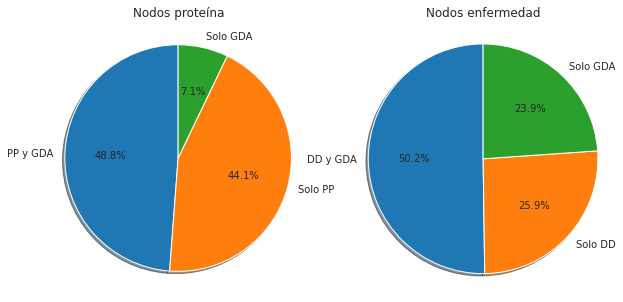

In [37]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].pie(k_prot, labels=["PP y GDA", "Solo PP", "Solo GDA"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[0].axis('equal') 
ax[0].set_title("Nodos proteína")

ax[1].pie(k_enf, labels=["DD y GDA", "Solo DD", "Solo GDA"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[1].axis('equal')
ax[1].set_title("Nodos enfermedad")

In [38]:
fig_pd_degree = px.histogram(graph_node_data[(graph_node_data.node_type == "gene_protein") & (graph_node_data.degree_gda !=0)]["degree_gda"], log_y=True, title="Distribución de grado: nodos gen -> nodos enfermedad")
fig_pd_degree.show()

In [39]:
fig_dp_degree = px.histogram(graph_node_data[(graph_node_data.node_type == "disease") & (graph_node_data.degree_gda !=0)]["degree_gda"], log_y=True, title="Distribución de grado: nodos enfermedad -> nodos gen")
fig_dp_degree.show()

# Comunidades - MESH

In [40]:
def nombre_mesh(meshclass):
    nombre = pd.unique(disease_attributes[disease_attributes.diseaseClassMSH == meshclass]["diseaseClassNameMSH"])
    return nombre

mesh_names = {mesh:nombre_mesh(mesh) for mesh in pd.unique(disease_attributes[~disease_attributes.diseaseClassMSH.isna()].diseaseClassMSH)}

In [41]:
mesh_col = disease_attributes[~disease_attributes.diseaseClassMSH.isna()]['diseaseClassMSH'].str.split(';').explode()
meshname_col = disease_attributes[~disease_attributes.diseaseClassMSH.isna()]['diseaseClassNameMSH'].str.split(';').explode()
mesh_df = pd.concat([mesh_col,meshname_col], axis=1).drop_duplicates(subset=["diseaseClassMSH"]).reset_index(drop=True)

In [42]:
disease_attr_communities = pd.merge(disease_attributes, graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]], left_on="node_index", right_on="node_index", how="left")

In [43]:
def mesh_from_cluster(cluster_id,method):
    if method == "infomap":
        cluster_nodes = disease_attr_communities[(disease_attr_communities.comunidades_infomap == cluster_id) & (disease_attr_communities.diseaseClassMSH.notna())]
        cluster_nodes_noclass = len(disease_attr_communities[(disease_attr_communities.comunidades_infomap == cluster_id) & (disease_attr_communities.diseaseClassMSH.isna())])
        total_nodes = len(disease_attr_communities[disease_attr_communities.comunidades_infomap == cluster_id])
    elif method == "louvain":
        cluster_nodes = disease_attr_communities[(disease_attr_communities.comunidades_louvain == cluster_id) & (disease_attr_communities.diseaseClassMSH.notna())]
        cluster_nodes_noclass = len(disease_attr_communities[(disease_attr_communities.comunidades_louvain == cluster_id) & (disease_attr_communities.diseaseClassMSH.isna())])
        total_nodes = len(disease_attr_communities[disease_attr_communities.comunidades_louvain == cluster_id])

    mesh_classes = cluster_nodes.diseaseClassMSH.values
    classes = []
    for value in mesh_classes:
        split = value.split(";")
        for mesh_class in split:
            classes.append(mesh_class)
    fig = px.histogram(classes, title=f"Clases de Mesh representadas en el cluster {cluster_id}").update_layout(xaxis_title="Mesh Class")
    fig.show()
    #print(f"Este cluster tiene {total_nodes} nodos, de los cuales {cluster_nodes_noclass} no tienen clase mesh. \nFueron contados {len(cluster_nodes)} nodos")
    print(f"Nodos en gráfico: {len(cluster_nodes)} \nNodos totales cluster: {total_nodes} \nNodos sin clase mesh: {cluster_nodes_noclass}")

In [44]:
mesh_df.sort_values(by="diseaseClassMSH")

,diseaseClassMSH,diseaseClassNameMSH
4,C01,Infections
13,C04,Neoplasms
8,C05,Musculoskeletal Diseases
7,C06,Digestive System Diseases
17,C07,Stomatognathic Diseases
16,C08,Respiratory Tract Diseases
18,C09,Otorhinolaryngologic Diseases
11,C10,Nervous System Diseases
5,C11,Eye Diseases
9,C12,Male Urogenital Diseases


In [45]:
tamaños_louvain

17     703
2      679
11     636
14     531
9      430
      ... 
238      2
123      2
240      2
94       2
217      2
Name: tamaño, Length: 266, dtype: int64

In [65]:
mesh_from_cluster(2,"louvain")

Nodos en gráfico: 565 
Nodos totales cluster: 679 
Nodos sin clase mesh: 114


También puedo ver entropía con "vectores mesh"

# Distancias intercapa

In [47]:
nodes_in_graph = np.unique(np.concatenate([graph_edge_data.x_index.astype("int").values,graph_edge_data.y_index.astype("int").values]))
graph_node_data[graph_node_data.node_index.apply(lambda x: x not in nodes_in_graph)].node_source.value_counts()
graph_node_data = graph_node_data[graph_node_data.node_index.apply(lambda x: x in nodes_in_graph)]
graph_node_data

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
0,0,1,A1BG,gene_protein,disgenet,NaN,NaN,2.0,12.0,0.0
1,1,10,NAT2,gene_protein,disgenet,NaN,NaN,39.0,6.0,0.0
2,2,100,ADA,gene_protein,disgenet,NaN,NaN,18.0,5.0,0.0
3,3,1000,CDH2,gene_protein,disgenet,NaN,NaN,28.0,15.0,0.0
4,4,10000,AKT3,gene_protein,disgenet,NaN,NaN,9.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...
36633,36633,SIGNOR-C93,MYOD1/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
36634,36634,SIGNOR-C94,Myog/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
36635,36635,SIGNOR-C95,CDON/BOC/PTCH1,complex,signor,NaN,NaN,0.0,3.0,0.0
36636,36636,SIGNOR-C97,RBPJ/NOTCH,complex,signor,NaN,NaN,0.0,2.0,0.0


In [48]:
nodos_intracapa = graph_node_data[graph_node_data.degree_gda == 0]
enf_intracapa = nodos_intracapa[(nodos_intracapa.node_type == "disease") | (nodos_intracapa.node_type == "bert_group")].node_index.astype("int").values
gen_intracapa = nodos_intracapa[(nodos_intracapa.node_type == "gene_protein")].node_index.astype("int").values
complejos_intracapa = nodos_intracapa[nodos_intracapa.node_type == "complex"].node_index.astype("int").values
pathways_intracapa = nodos_intracapa[nodos_intracapa.node_type == "pathway"].node_index.astype("int").values

#all_genes = graph_node_data[graph_node_data.node_type == "gene/protein"].node_index.values
#all_enf = graph_node_data[graph_node_data.node_type == "disease"].node_index.values
gen_intercapa = graph_node_data[(graph_node_data.degree_gda != 0) & (graph_node_data.node_type == "gene_protein")].node_index.astype("int").values
enf_intercapa = graph_node_data[(graph_node_data.degree_gda != 0) & (graph_node_data.node_type == "disease")].node_index.astype("int").values

Armo una versión igraph de mi grafo. Como igraph usa otra forma de indexar los nodos, me armo diccionarios para "traducir" entre mi nomenclatura y la de igraph.

In [49]:
G_igraph = ig.Graph.TupleList(G.edges(), directed=False)

#Tengo que "traducir" los ids de mi grafo a ids de igraph
vid2name = dict(zip(range(G_igraph.vcount()), G_igraph.vs['name']))
name2vid = dict((name, vid) for vid, name in vid2name.items())
gen_intercapa_vid = [name2vid[gen] for gen in gen_intercapa]
enf_intercapa_vid = [name2vid[enf] for enf in enf_intercapa]

In [50]:
results_enf = {}
for enf in enf_intracapa:
    igraph_id = name2vid[enf]
    results_enf[enf] = min(G_igraph.shortest_paths(igraph_id,gen_intercapa_vid,mode="out")[0])

In [51]:
results_gen = {}
for gen in gen_intracapa:
    igraph_id = name2vid[gen]
    results_gen[gen] = min(G_igraph.shortest_paths(igraph_id,enf_intercapa_vid,mode="out")[0])

In [52]:
results_complex = {}
for com in complejos_intracapa:
    igraph_id = name2vid[com]
    results_complex[com] = min(G_igraph.shortest_paths(igraph_id,enf_intercapa_vid,mode="out")[0])

In [53]:
results_pathway = {}
for pth in pathways_intracapa:
    igraph_id = name2vid[pth]
    results_pathway[pth] = min(G_igraph.shortest_paths(igraph_id,enf_intercapa_vid,mode="out")[0])

In [54]:
shortest_interlayer_length = pd.Series(pd.concat([pd.Series(results_enf, dtype="float64"),pd.Series(results_gen, dtype="float64"), pd.Series(results_complex, dtype="float64"),pd.Series(results_pathway, dtype="float64")]),name="Shortest_interlayer_length")

#le asigno valor negativo a los nodos totalmente desconectados de la otra capa
shortest_interlayer_length = shortest_interlayer_length.apply(lambda x: -1 if x == float("inf") else x)
node_interlayer_data = graph_node_data.join(shortest_interlayer_length, on="node_index")
node_interlayer_data.loc[(graph_node_data["degree_gda"] != 0), 'Shortest_interlayer_length'] = 1

In [71]:
#node_interlayer_data.to_csv(data_processed+"grafo_alternativo_CG_analisis_grado.csv",index=False)

Para armar figura de 2*3 con todos los gráficos juntos

In [ ]:
# pathways = analisis_grado[analisis_grado.node_type == "pathway"]
# complexes = analisis_grado[analisis_grado.node_type == "complex"]
# genes = analisis_grado[analisis_grado.node_type == "gene_protein"]
# diseases = analisis_grado[analisis_grado.node_type == "disease"]
# berts = analisis_grado[analisis_grado.node_type == "bert_group"]

# cases = {"Todos":analisis_grado, "Enfermedades":diseases, "Genes":genes, "Complejos":complexes, "Pathways":pathways,"BERTs":berts}


# plt.figure(figsize=(24, 12))
# plt.subplots_adjust(hspace=0.5)
# plt.suptitle("Distancia mínima a la otra capa", fontsize=18, y=0.95)

# for n, data in enumerate(cases.items()):
#     ax = plt.subplot(2, 3, n + 1)
#     title = data[0]
#     x = data[1]
#     sns.histplot(data=x, x="Shortest_interlayer_length", ax=ax, bins=[1,2,3,4,5,6,7])
#     ax.set_title(title)
#     ax.set_xlabel("Distancia mínima")

# # plt.savefig("../../reports/distancias.png", dpi=150)

In [56]:
interlayer_fig = px.histogram(node_interlayer_data["Shortest_interlayer_length"], title="All types and cases")
interlayer_fig.show()

In [57]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "disease", "Shortest_interlayer_length"], title="Diseases")
interlayer_fig.show()

In [58]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "gene_protein", "Shortest_interlayer_length"], title="Genes")
interlayer_fig.show()

In [59]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "bert_group", "Shortest_interlayer_length"], title="Bert Groups")
interlayer_fig.show()

In [60]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "complex", "Shortest_interlayer_length"], title="Protein Complex")
interlayer_fig.show()

In [61]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "pathway", "Shortest_interlayer_length"], title="Pathways")
interlayer_fig.show()